In [18]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import os


df = pd.read_csv(r"C:\Users\Asus\Downloads\eth-btc-orderbooks.csv")

# проверим, как выглядит
df.head()


,timestamp,asks,bids
0,2025-09-01 00:13:09.511132300+00:00,"[{'price': 0.04100829, 'size': 0.02288708}, {'...","[{'price': 0.0405, 'size': 0.00249086}, {'pric..."
1,2025-09-01 00:31:23.134173200+00:00,"[{'price': 0.04097411, 'size': 0.02047798}, {'...","[{'price': 0.0405, 'size': 0.00249086}, {'pric..."
2,2025-09-01 00:49:37.173137500+00:00,"[{'price': 0.04091134, 'size': 0.02229217}, {'...","[{'price': 0.0405, 'size': 0.00249086}, {'pric..."
3,2025-09-01 01:07:51.274078600+00:00,"[{'price': 0.04103079, 'size': 0.07205901}, {'...","[{'price': 0.0405, 'size': 0.00249086}, {'pric..."
4,2025-09-01 01:26:07.248503+00:00,"[{'price': 0.04100837, 'size': 0.02019721}, {'...","[{'price': 0.0405, 'size': 0.00249086}, {'pric..."


In [2]:
def parse_orderbook_side(df, side):
    records = []

    for _, row in df.iterrows():
        timestamp = pd.to_datetime(row["timestamp"])
        orders = ast.literal_eval(row[side])

        for order in orders:
            records.append({
                "timestamp": timestamp,
                "side": side[:-1],  # ask / bid
                "price": float(order["price"]),
                "size": float(order["size"])
            })

    return pd.DataFrame(records)


In [3]:
asks_df = parse_orderbook_side(df, "asks")
bids_df = parse_orderbook_side(df, "bids")

orderbook_df = pd.concat([asks_df, bids_df], ignore_index=True)
orderbook_df.head()


,timestamp,side,price,size
0,2025-09-01 00:13:09.511132300+00:00,ask,0.041008,0.022887
1,2025-09-01 00:13:09.511132300+00:00,ask,0.041090,0.002495
2,2025-09-01 00:13:09.511132300+00:00,ask,0.041100,0.002460
3,2025-09-01 00:13:09.511132300+00:00,ask,0.041123,0.009358
4,2025-09-01 00:13:09.511132300+00:00,ask,0.041171,0.102892


In [4]:
best_ask = (
    orderbook_df[orderbook_df["side"] == "ask"]
    .groupby("timestamp")["price"]
    .min()
)

best_bid = (
    orderbook_df[orderbook_df["side"] == "bid"]
    .groupby("timestamp")["price"]
    .max()
)

orderbook_metrics = pd.DataFrame({
    "best_bid": best_bid,
    "best_ask": best_ask
})

orderbook_metrics["spread"] = (
    orderbook_metrics["best_ask"] - orderbook_metrics["best_bid"]
)

orderbook_metrics["mid_price"] = (
    orderbook_metrics["best_ask"] + orderbook_metrics["best_bid"]
) / 2

orderbook_metrics.head()

,best_bid,best_ask,spread,mid_price
timestamp,,,,
2025-09-01 00:13:09.511132300+00:00,0.0405,0.041008,0.000508,0.040754
2025-09-01 00:31:23.134173200+00:00,0.0405,0.040974,0.000474,0.040737
2025-09-01 00:49:37.173137500+00:00,0.0405,0.040911,0.000411,0.040706
2025-09-01 01:07:51.274078600+00:00,0.0405,0.041031,0.000531,0.040765
2025-09-01 01:26:07.248503+00:00,0.0405,0.041008,0.000508,0.040754


In [6]:
orderbook_df[orderbook_df["side"] == "bid"]["price"].nunique()

107

In [7]:
orderbook_df[orderbook_df["side"] == "ask"]["price"].nunique()


251

In [8]:
orderbook_df["size"].value_counts().head(15)


size
0.002500    690
0.002000    238
0.000247    188
0.003699    188
0.000248    188
0.002728    188
0.002883    188
0.000263    188
0.002472    188
0.000248    188
0.000247    188
0.012218    188
0.000260    188
0.002495    188
0.009358    188
Name: count, dtype: int64

In [9]:
ts = orderbook_df["timestamp"].min()

snapshot = orderbook_df[orderbook_df["timestamp"] == ts]


In [10]:
bids = snapshot[snapshot["side"] == "bid"].sort_values("price", ascending=False)
asks = snapshot[snapshot["side"] == "ask"].sort_values("price")

bids["cum_size"] = bids["size"].cumsum()
asks["cum_size"] = asks["size"].cumsum()

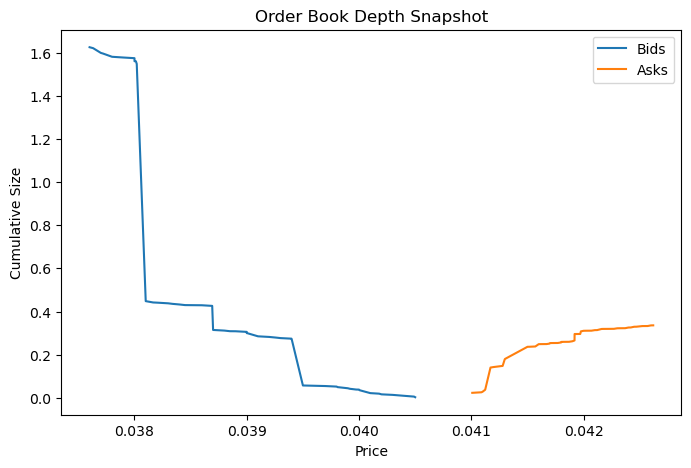

In [11]:
plt.figure(figsize=(8, 5))
plt.plot(bids["price"], bids["cum_size"], label="Bids")
plt.plot(asks["price"], asks["cum_size"], label="Asks")
plt.xlabel("Price")
plt.ylabel("Cumulative Size")
plt.title("Order Book Depth Snapshot")
plt.legend()
plt.savefig("figures/orderbook_depth.png", bbox_inches="tight")
plt.show()

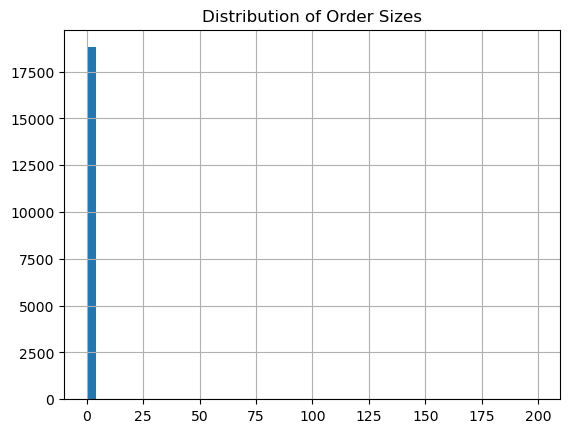

In [12]:
orderbook_df["size"].hist(bins=50)
plt.title("Distribution of Order Sizes")
plt.savefig("figures/order_size_distribution.png", bbox_inches="tight")
plt.show()

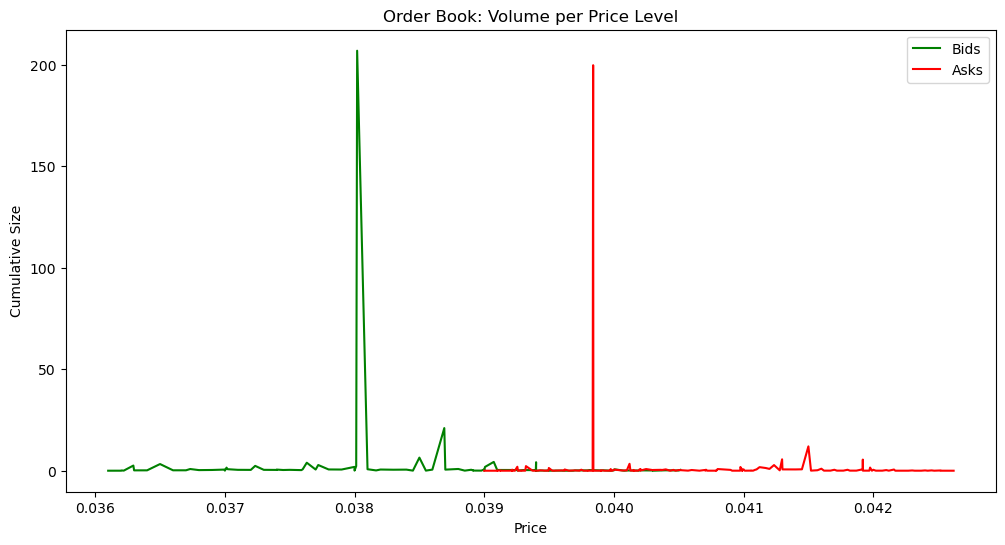

In [13]:
# Суммарный объем на каждом уровне цены
asks_volume = orderbook_df[orderbook_df["side"] == "ask"].groupby("price")["size"].sum().reset_index()
bids_volume = orderbook_df[orderbook_df["side"] == "bid"].groupby("price")["size"].sum().reset_index()

# Визуализация объемов по цене
plt.figure(figsize=(12,6))
plt.plot(bids_volume["price"], bids_volume["size"], label="Bids", color="green")
plt.plot(asks_volume["price"], asks_volume["size"], label="Asks", color="red")
plt.xlabel("Price")
plt.ylabel("Cumulative Size")
plt.title("Order Book: Volume per Price Level")
plt.legend()
plt.show()

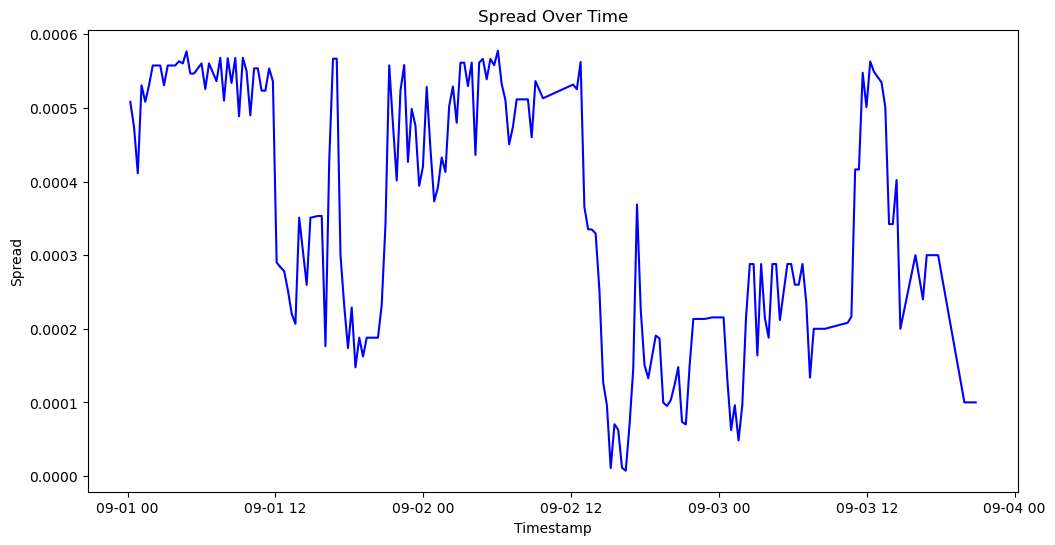

In [14]:
# График спреда по времени
plt.figure(figsize=(12,6))
plt.plot(orderbook_metrics.index, orderbook_metrics["spread"], color="blue")
plt.xlabel("Timestamp")
plt.ylabel("Spread")
plt.title("Spread Over Time")
plt.savefig("figures/spread_over_time.png", bbox_inches="tight")
plt.show()


In [15]:
# Определим 95-й процентиль объёма для bids и asks
bids_threshold = bids_volume["size"].quantile(0.95)
asks_threshold = asks_volume["size"].quantile(0.95)

# Фильтруем "аномальные" уровни
anomalous_bids = bids_volume[bids_volume["size"] > bids_threshold]
anomalous_asks = asks_volume[asks_volume["size"] > asks_threshold]

print("Suspicious Bid Levels:\n", anomalous_bids)
print("Suspicious Ask Levels:\n", anomalous_asks)


Suspicious Bid Levels:
        price        size
28  0.037632    3.940679
36  0.038020  206.800000
44  0.038500    6.449318
47  0.038692   20.989747
60  0.039074    4.339339
68  0.039400    4.188682
Suspicious Ask Levels:
         price        size
40   0.039255    1.956607
50   0.039322    2.265545
62   0.039498    1.338324
87   0.039840  199.665000
121  0.040121    3.413872
167  0.040976    1.836677
200  0.041123    1.759240
201  0.041171    1.337600
203  0.041235    2.778093
205  0.041297    5.606465
209  0.041500   11.990782
225  0.041920    5.485489
228  0.041976    1.559988


In [15]:
trades_df = pd.read_csv(r"C:\Users\Asus\Downloads\eth-btc-trades.csv")
trades_df.head()

,timestamp,price,size,side
0,2025-09-01 00:02:57+00:00,0.040800,0.000441,SELL
1,2025-09-01 00:02:57+00:00,0.040700,0.002478,SELL
2,2025-09-01 00:02:57+00:00,0.040700,0.020152,SELL
3,2025-09-01 00:02:57+00:00,0.040600,0.002460,SELL
4,2025-09-01 00:03:14+00:00,0.040812,91.455503,BUY


In [17]:
trades_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 845 entries, 0 to 844
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  845 non-null    object 
 1   price      845 non-null    float64
 2   size       845 non-null    float64
 3   side       845 non-null    object 
dtypes: float64(2), object(2)
memory usage: 26.5+ KB


In [18]:
trades_df["size"].describe()


count    8.450000e+02
mean     1.991701e+02
std      1.819366e+02
min      5.600000e-07
25%      5.359826e+01
50%      1.581660e+02
75%      2.952466e+02
max      6.873292e+02
Name: size, dtype: float64

In [19]:
trades_df["size"].value_counts().head(10)


size
0.000261      13
137.808000     5
399.330000     5
70.470000      5
101.790000     4
62.640000      4
187.920000     4
183.222000     3
281.880000     3
328.860000     3
Name: count, dtype: int64

In [16]:
# Приведем timestamp (формально)
trades_df["timestamp"] = pd.to_datetime(trades_df["timestamp"])

# сделки около bid wall
bid_wall_trades = trades_df[
    trades_df["price"].between(0.0379, 0.0381)
]

# сделки около ask wall
ask_wall_trades = trades_df[
    trades_df["price"].between(0.0397, 0.0400)
]

len(bid_wall_trades), len(ask_wall_trades)


(0, 266)

In [21]:
bid_wall_trades["size"].sum(), ask_wall_trades["size"].sum()


(np.float64(0.0), np.float64(58038.22073731))

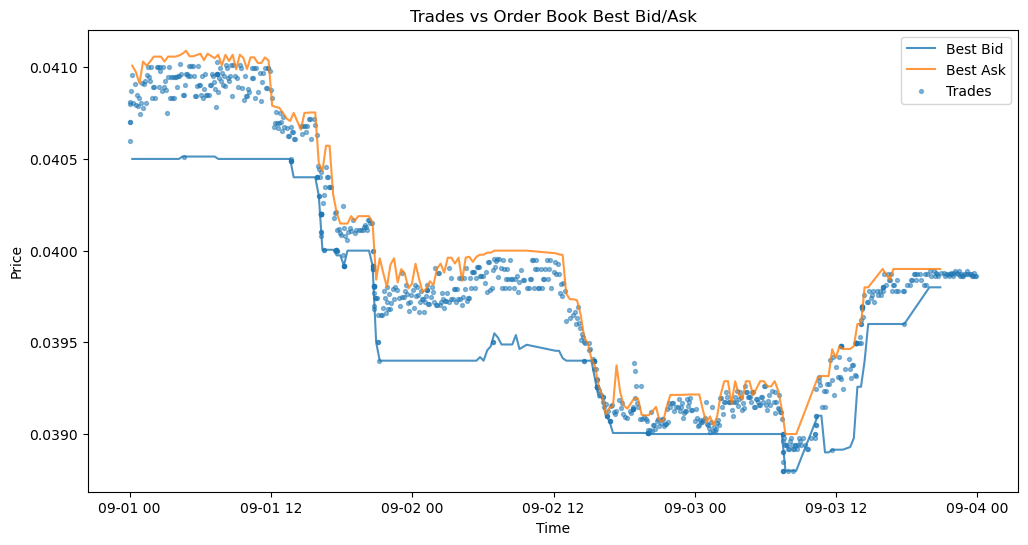

In [17]:
plt.figure(figsize=(12,6))

# best bid / ask
plt.plot(orderbook_metrics.index, orderbook_metrics["best_bid"], label="Best Bid", alpha=0.8)
plt.plot(orderbook_metrics.index, orderbook_metrics["best_ask"], label="Best Ask", alpha=0.8)

# trades
plt.scatter(trades_df["timestamp"], trades_df["price"], s=8, alpha=0.5, label="Trades")

plt.xlabel("Time")
plt.ylabel("Price")
plt.title("Trades vs Order Book Best Bid/Ask")
plt.legend()
plt.savefig("figures/trades_vs_best_bid_ask.png", bbox_inches="tight")
plt.show()

In [20]:
os.getcwd()

'C:\\Users\\Asus\\anaconda3\\Scripts'